# Integrated EDA & Feature Engineering (통합 EDA 및 특징 공학)

이 노트북은 AI와 Human 텍스트를 구분하기 위한 심층적인 데이터 탐색(EDA)과 특징 선택(Feature Selection) 과정을 통합한 최종 결과물입니다.
사용자의 요청에 따라 **품사 비율(POS Ratios) 특징은 분석에서 제외**되었습니다.

## 분석 목차
**I. 데이터 준비 및 전처리**
1. 데이터 로드 및 정제
2. 파생 변수 생성 (Perplexity, Punctuation Count)

**II. 특징별 상세 탐색 (Feature Exploration)**
각 특징의 분포를 시각화하고, **기술 통계량(Min, Max, Mean, Median, Std)**을 함께 확인합니다.
1. **Word Count (단어 수)**
2. **Sentence Count (문장 수)**
3. **Average Sentence Length (평균 문장 길이)**
4. **Burstiness (문장 길이 분산)**
5. **Perplexity (펄플렉서티)**
6. **Type-Token Ratio (TTR)**
7. **Readability (가독성)**
8. **Sentiment (감성 점수)**
9. **Subjectivity (주관성 점수)**
10. **Punctuation Count (구두점 개수)**

**III. 통계적 검증 및 특징 선택**
1. **Mann-Whitney U Test**: 통계적 유의성 검정
2. **Random Forest Feature Importance**: 모델 기반 중요도 분석
3. **최종 특징 선정**: 유의미한 특징을 선별하여 저장

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import string
from scipy import stats
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split
from IPython.display import display

# 한글 폰트 설정 (Windows)
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False
sns.set_theme(style="whitegrid", context="talk")
PALETTE = {'Human': '#3498DB', 'AI': '#E74C3C'}

# 데이터 로드
DATA_PATH = "../data/english_train_with_features.csv"
try:
    df = pd.read_csv(DATA_PATH)
    # Perplexity 파생변수 생성 (2^Entropy)
    if 'entropy' in df.columns:
        df['perplexity'] = 2 ** df['entropy']
    # 구두점 개수 파생변수 생성
    if 'punct_count' not in df.columns:
        df['punct_count'] = df['text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))
    
    # 레이블 매핑 (시각화용)
    df['label_str'] = df['generated'].map({0: 'Human', 1: 'AI'})
        
    print(f"데이터 로드 완료: {df.shape}")
except FileNotFoundError:
    print("데이터 파일을 찾을 수 없습니다. src/perform_english_eda.py를 먼저 실행해주세요.")

def show_stats(feature_name):
    print(f"[{feature_name} Statistics]")
    stats_df = df.groupby('label_str')[feature_name].agg(['min', 'max', 'mean', 'median', 'std'])
    display(stats_df)

데이터 로드 완료: (10000, 18)


## II. 특징별 상세 탐색 (Feature Exploration)

각 특징의 정의, 계산 방법, 그리고 AI와 Human 텍스트 간의 차이를 시각적으로 분석합니다.

### 1. Word Count (단어 수)
- **정의**: 텍스트에 포함된 총 단어의 개수입니다.
- **의미**: 텍스트의 길이를 나타냅니다. AI 모델은 프롬프트에 따라 일정한 길이의 응답을 생성하는 경향이 있을 수 있습니다.

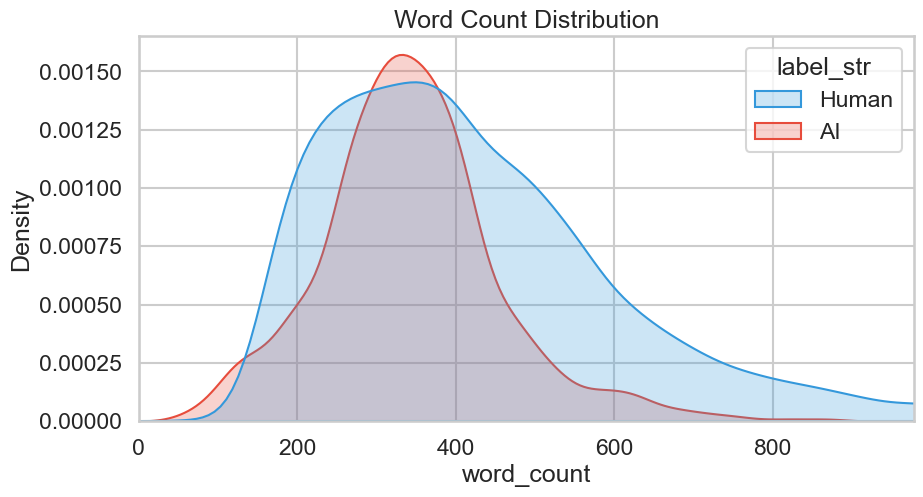

[word_count Statistics]


,min,max,mean,median,std
label_str,,,,,
AI,50,883,342.701524,336.0,113.830029
Human,75,1366,422.731999,389.0,189.587658


In [18]:
plt.figure(figsize=(10, 5))
sns.kdeplot(data=df, x='word_count', hue='label_str', fill=True, palette=PALETTE)
plt.title('Word Count Distribution')
plt.xlim(0, df['word_count'].quantile(0.99))
plt.show()

show_stats('word_count')

### 2. Sentence Count (문장 수)
- **정의**: 텍스트에 포함된 총 문장의 개수입니다.
- **의미**: 텍스트의 구조적 복잡성을 나타내는 지표 중 하나입니다.

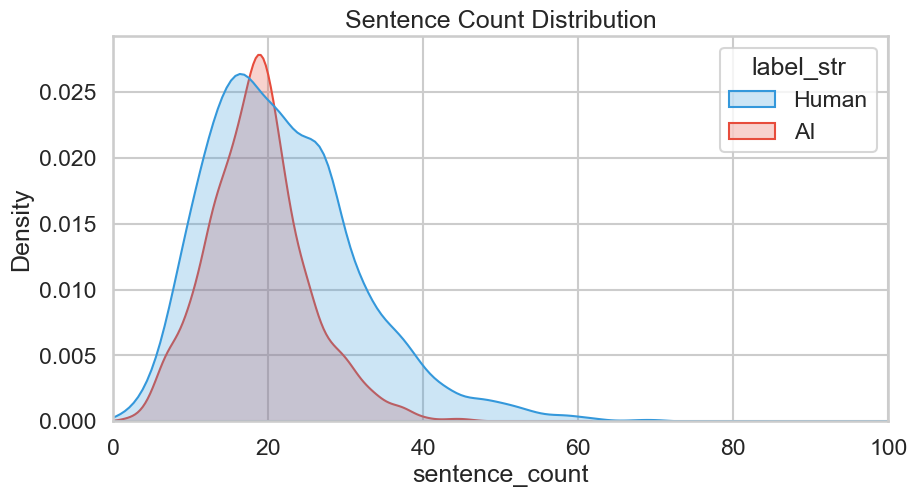

[sentence_count Statistics]


,min,max,mean,median,std
label_str,,,,,
AI,1,58,18.646611,18.0,6.511966
Human,1,104,21.937682,21.0,10.085873


In [19]:
plt.figure(figsize=(10, 5))
sns.kdeplot(data=df, x='sentence_count', hue='label_str', fill=True, palette=PALETTE)
plt.title('Sentence Count Distribution')
plt.xlim(0, 100)
plt.show()

show_stats('sentence_count')

### 3. Average Sentence Length (평균 문장 길이)
- **정의**: 문장당 평균 단어 수입니다.
- **의미**: 문장의 호흡을 나타냅니다. AI는 종종 명확하고 간결한 문장을 구사하여 평균 길이가 짧거나 일정한 경향이 있습니다.

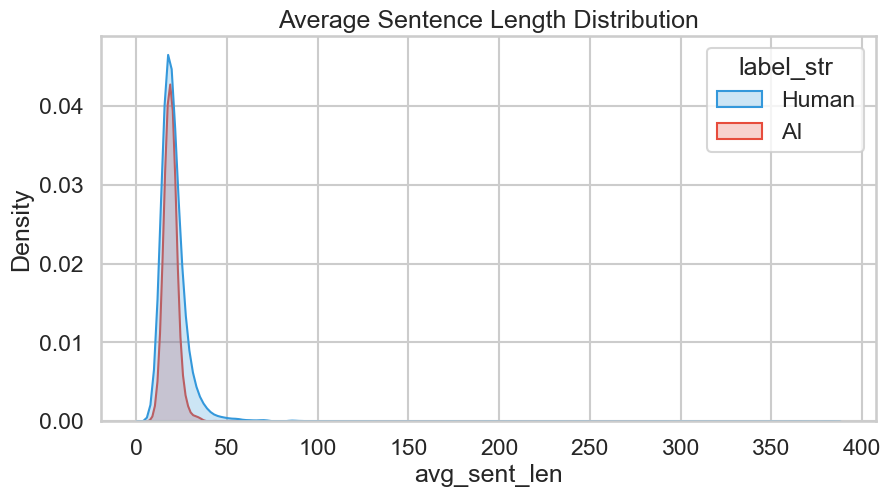

[avg_sent_len Statistics]


,min,max,mean,median,std
label_str,,,,,
AI,6.918919,279.0,19.008834,18.550000,6.709033
Human,6.745098,381.0,20.993124,18.928571,13.262642


In [20]:
plt.figure(figsize=(10, 5))
sns.kdeplot(data=df, x='avg_sent_len', hue='label_str', fill=True, palette=PALETTE)
plt.title('Average Sentence Length Distribution')
plt.show()

show_stats('avg_sent_len')

### 4. Burstiness (문장 길이의 분산)
- **정의**: 문장 길이의 변화 정도를 나타내는 지표 (분산 / 평균^2).
- **의미**: 글의 리듬감을 나타냅니다. 인간의 글은 짧은 문장과 긴 문장이 섞여 있어 Burstiness가 높은 반면, AI는 일정한 패턴을 보일 수 있습니다.

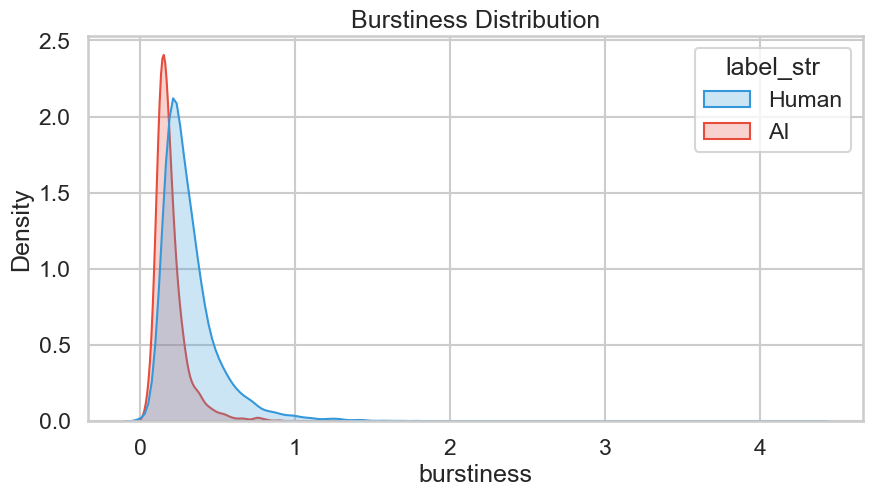

[burstiness Statistics]


,min,max,mean,median,std
label_str,,,,,
AI,0.0,1.635613,0.199350,0.167215,0.127336
Human,0.0,4.323399,0.325626,0.271257,0.208713


In [21]:
plt.figure(figsize=(10, 5))
sns.kdeplot(data=df, x='burstiness', hue='label_str', fill=True, palette=PALETTE)
plt.title('Burstiness Distribution')
plt.show()

show_stats('burstiness')

### 5. Perplexity (펄플렉서티)
- **정의**: 텍스트의 예측 불가능성 또는 복잡도 (2^Entropy).
- **의미**: 수치가 높을수록 텍스트가 더 다양하고 예측하기 어렵다는 뜻입니다. 인간의 글은 AI보다 더 높은 Perplexity를 가질 것으로 예상됩니다.

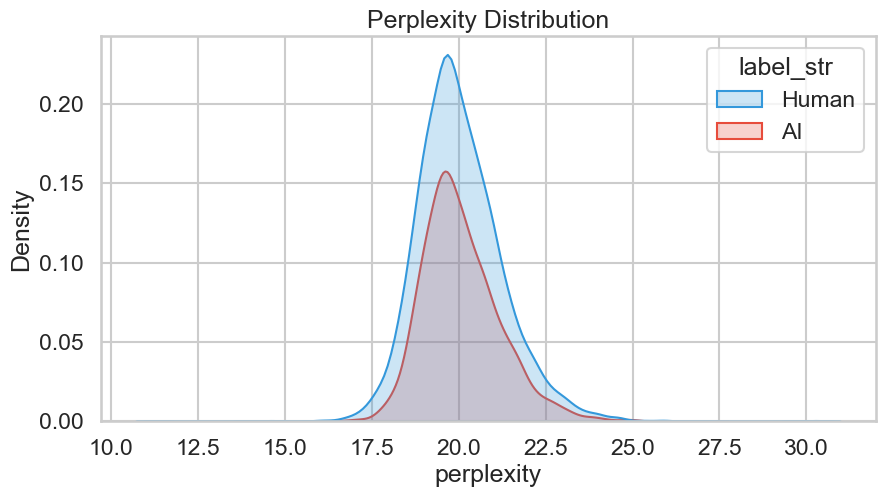

[perplexity Statistics]


,min,max,mean,median,std
label_str,,,,,
AI,16.563049,27.112558,20.061830,19.897953,1.118084
Human,11.368891,30.323499,20.028528,19.884587,1.243136


In [22]:
plt.figure(figsize=(10, 5))
sns.kdeplot(data=df, x='perplexity', hue='label_str', fill=True, palette=PALETTE)
plt.title('Perplexity Distribution')
plt.show()

show_stats('perplexity')

### 6. Type-Token Ratio (TTR, 어휘 다양성)
- **정의**: 전체 단어 수 대비 고유한 단어(Unique Words)의 비율.
- **의미**: 어휘의 다양성을 나타냅니다. 같은 단어를 반복해서 쓰면 TTR이 낮아집니다.

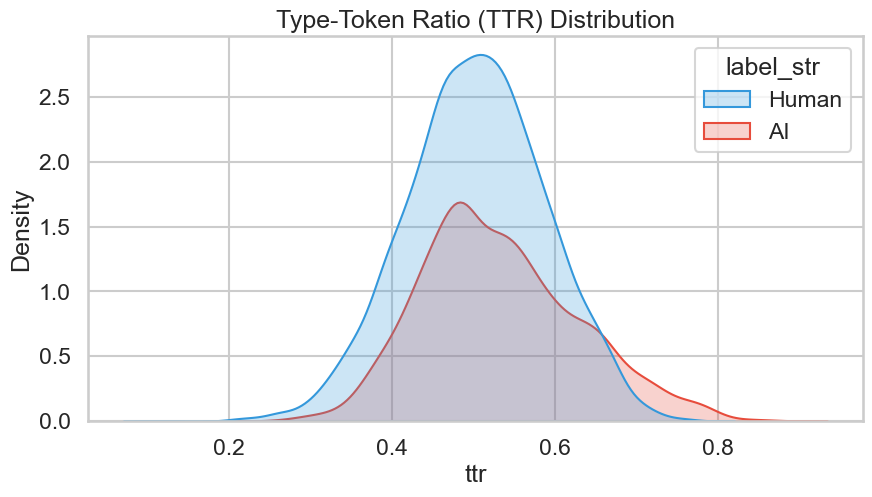

[ttr Statistics]


,min,max,mean,median,std
label_str,,,,,
AI,0.241935,0.878453,0.531079,0.520790,0.096839
Human,0.114103,0.776042,0.502477,0.503312,0.085285


In [23]:
plt.figure(figsize=(10, 5))
sns.kdeplot(data=df, x='ttr', hue='label_str', fill=True, palette=PALETTE)
plt.title('Type-Token Ratio (TTR) Distribution')
plt.show()

show_stats('ttr')

### 7. Readability (가독성 지수)
- **정의**: Flesch Reading Ease 점수.
- **의미**: 점수가 높을수록 읽기 쉽고, 낮을수록 어렵습니다. AI는 일반적으로 명확하고 평이한 문장을 생성하는 경향이 있습니다.

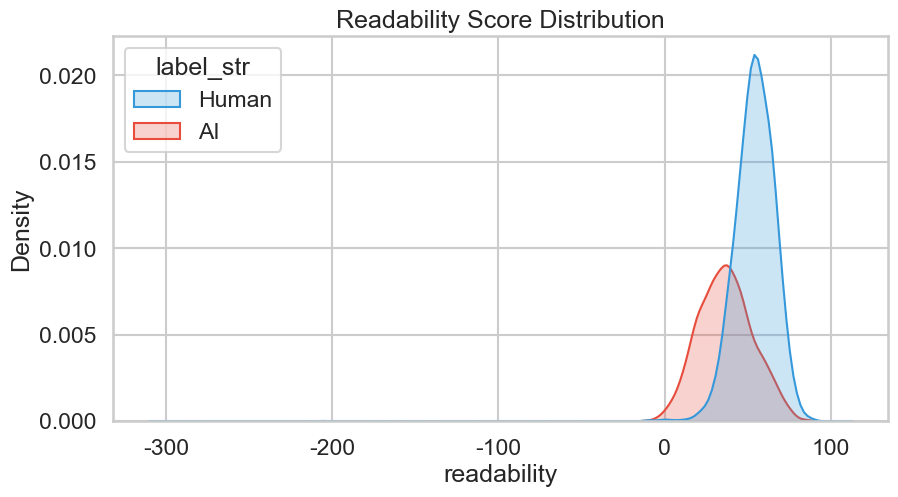

[readability Statistics]


,min,max,mean,median,std
label_str,,,,,
AI,-216.137097,93.624657,36.469347,36.192893,17.114329
Human,-302.228031,105.189590,53.610521,54.517753,15.801583


In [24]:
plt.figure(figsize=(10, 5))
sns.kdeplot(data=df, x='readability', hue='label_str', fill=True, palette=PALETTE)
plt.title('Readability Score Distribution')
plt.show()

show_stats('readability')

### 8. Sentiment (감성 점수)
- **정의**: 텍스트의 긍정/부정 정도 (-1 ~ 1).
- **의미**: AI는 중립적이거나 긍정적인 톤을 유지하려는 경향이 있는 반면, 인간의 글은 감정 표현이 더 다양할 수 있습니다.

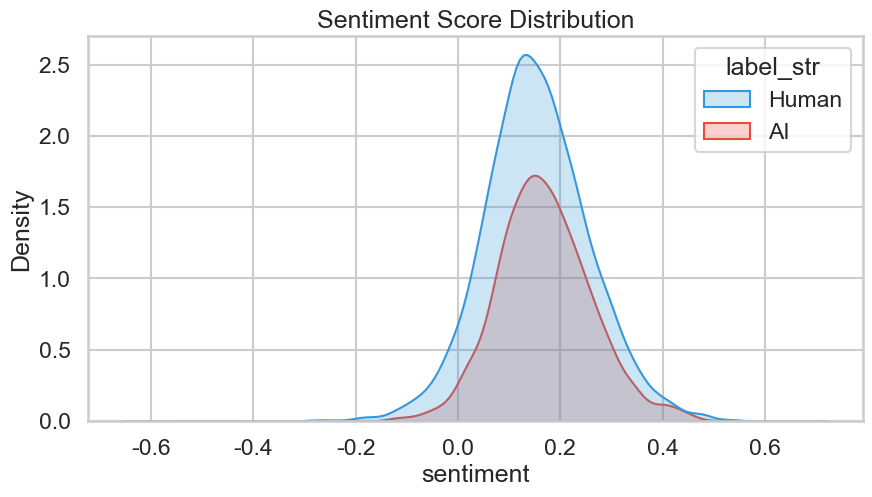

[sentiment Statistics]


,min,max,mean,median,std
label_str,,,,,
AI,-0.289057,0.549908,0.168453,0.163331,0.093749
Human,-0.600000,0.667500,0.152699,0.148511,0.104734


In [25]:
plt.figure(figsize=(10, 5))
sns.kdeplot(data=df, x='sentiment', hue='label_str', fill=True, palette=PALETTE)
plt.title('Sentiment Score Distribution')
plt.show()

show_stats('sentiment')

### 9. Subjectivity (주관성 점수)
- **정의**: 텍스트의 주관적/객관적 정도 (0 ~ 1).
- **의미**: 인간의 글은 개인적인 경험이나 의견이 포함되어 주관성이 높을 수 있습니다.

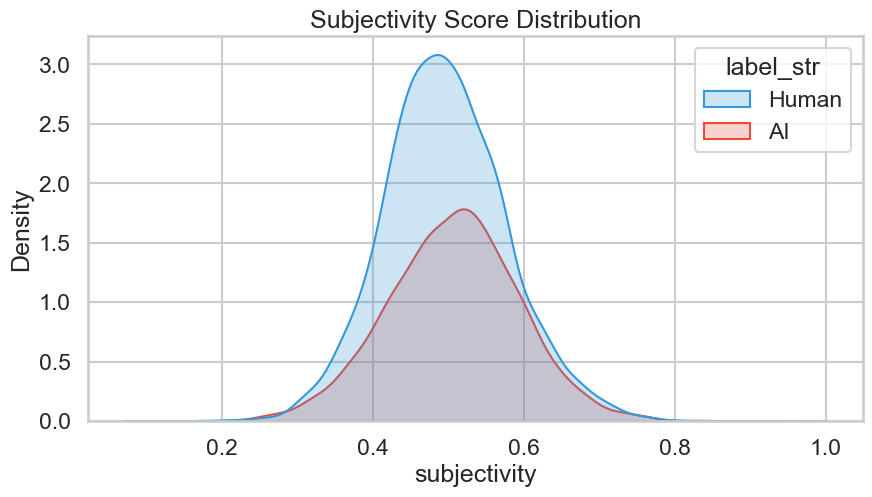

[subjectivity Statistics]


,min,max,mean,median,std
label_str,,,,,
AI,0.187026,0.951724,0.506407,0.509204,0.088078
Human,0.111111,0.916667,0.495153,0.491949,0.082049


In [26]:
plt.figure(figsize=(10, 5))
sns.kdeplot(data=df, x='subjectivity', hue='label_str', fill=True, palette=PALETTE)
plt.title('Subjectivity Score Distribution')
plt.show()

show_stats('subjectivity')

### 10. Punctuation Count (구두점 개수)
- **정의**: 텍스트에 포함된 구두점(., ?, !, ,, " 등)의 총 개수.
- **의미**: 문장 구조의 복잡성이나 스타일을 반영합니다. 과도한 구두점 사용이나 특정 패턴은 인간 글의 특징일 수 있습니다.

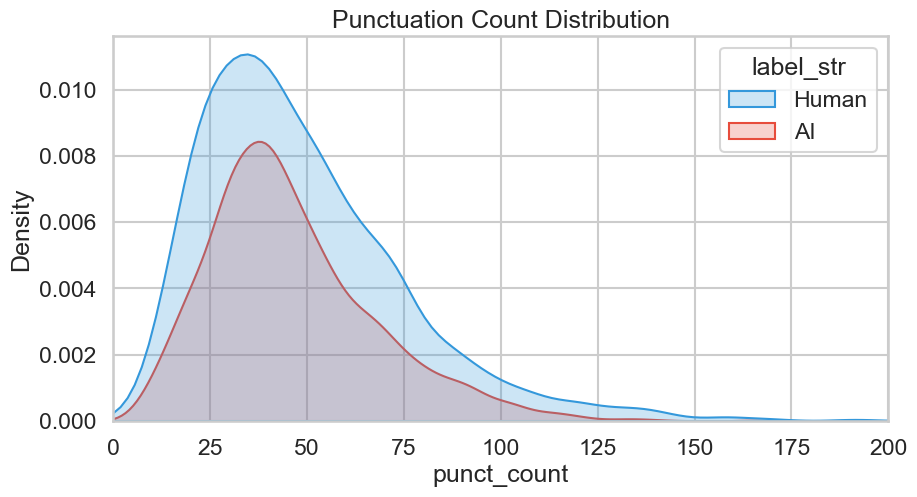

[punct_count Statistics]


,min,max,mean,median,std
label_str,,,,,
AI,6,175,46.281398,42.0,22.103493
Human,0,334,49.009848,44.0,27.793919


In [27]:
plt.figure(figsize=(10, 5))
sns.kdeplot(data=df, x='punct_count', hue='label_str', fill=True, palette=PALETTE)
plt.title('Punctuation Count Distribution')
plt.xlim(0, 200)
plt.show()

show_stats('punct_count')

## III. 통계적 검증 및 특징 선택

위에서 시각적으로 확인한 차이가 통계적으로 유의미한지 검증하고, 모델 학습에 사용할 최종 특징을 선택합니다.

In [28]:
# 분석할 특징 목록 (POS 관련 특징 제외됨)
feature_cols = [
    'word_count', 'sentence_count', 'avg_sent_len', 'burstiness', 
    'perplexity', 'ttr', 'readability', 
    'sentiment', 'subjectivity', 'punct_count'
]

df_features = df[feature_cols].fillna(0)
target = df['generated']

human_data = df_features[target == 0]
ai_data = df_features[target == 1]

significant_features_stats = []
p_value_threshold = 0.001

print(f"{'Feature':<20} | {'P-Value':<15} | {'Result'}")
print("-" * 50)

for feature in feature_cols:
    stat, p_val = stats.mannwhitneyu(human_data[feature], ai_data[feature], alternative='two-sided')
    is_significant = p_val < p_value_threshold
    result_str = "Significant" if is_significant else "Not Significant"
    print(f"{feature:<20} | {p_val:.4e}     | {result_str}")
    
    if is_significant:
        significant_features_stats.append(feature)

print(f"\n통계적으로 유의미한 특징 ({len(significant_features_stats)}개): {significant_features_stats}")

Feature              | P-Value         | Result
--------------------------------------------------
word_count           | 4.8186e-80     | Significant
sentence_count       | 2.0053e-48     | Significant
avg_sent_len         | 9.8495e-12     | Significant
burstiness           | 0.0000e+00     | Significant
perplexity           | 1.4558e-01     | Not Significant
ttr                  | 2.0323e-33     | Significant
readability          | 0.0000e+00     | Significant
sentiment            | 1.6990e-14     | Significant
subjectivity         | 1.1322e-13     | Significant
punct_count          | 2.5618e-02     | Not Significant

통계적으로 유의미한 특징 (8개): ['word_count', 'sentence_count', 'avg_sent_len', 'burstiness', 'ttr', 'readability', 'sentiment', 'subjectivity']


### Random Forest Feature Importance

In [29]:
X_train, X_test, y_train, y_test = train_test_split(df_features, target, test_size=0.2, random_state=42)

rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)

importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]

print("Feature Ranking:")
for f in range(len(feature_cols)):
    idx = indices[f]
    print(f"{f + 1}. {feature_cols[idx]} ({importances[idx]:.4f})")

# 평균 중요도 이상인 특징 선택
selector = SelectFromModel(rf, prefit=True, threshold='mean')
selected_mask = selector.get_support()
significant_features_rf = [feature_cols[i] for i in range(len(feature_cols)) if selected_mask[i]]

print(f"\nRF 중요도 기준 선택 ({len(significant_features_rf)}개): {significant_features_rf}")

Feature Ranking:
1. readability (0.3289)
2. burstiness (0.1750)
3. word_count (0.1107)
4. avg_sent_len (0.0806)
5. punct_count (0.0721)
6. ttr (0.0598)
7. sentence_count (0.0541)
8. sentiment (0.0402)
9. perplexity (0.0394)
10. subjectivity (0.0392)

RF 중요도 기준 선택 (3개): ['word_count', 'burstiness', 'readability']


### 최종 특징 저장

In [30]:
final_selected_features = list(set(significant_features_stats) & set(significant_features_rf))

if len(final_selected_features) < 3:
    print("교집합이 너무 적어 RF 중요도 기준을 따릅니다.")
    final_selected_features = significant_features_rf

print(f"최종 선별된 특징 ({len(final_selected_features)}개): {final_selected_features}")

with open("../data/selected_features.txt", "w") as f:
    for feature in final_selected_features:
        f.write(f"{feature}\n")

최종 선별된 특징 (3개): ['readability', 'burstiness', 'word_count']
